1. Data Preprocessing


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report


# Load dataset
data = pd.read_csv('/content/cn_dataset.csv')

# Data preprocessing
if 'Date' in data.columns:
    data.drop(columns=['Date'], inplace=True)
if 'IP_Address' in data.columns:
    data.drop(columns=['IP_Address'], inplace=True)

 # Define the maintenance need criteria
data['Maintenance_Needed'] = np.where(
    (data['CPU_Utilization'] > 80) |
    (data['Memory_Utilization'] > 85) |
    (data['System_Patch_Status'] == 'Outdated'), 1, 0
)
# Add spikes (placeholder values and thresholds)
data['CPU_Spike'] = data['CPU_Utilization'] > 0.80
data['Memory_Spike'] = data['Memory_Utilization'] > 0.85

# Adjust Maintenance_Needed based on spikes and patch status
data['Maintenance_Needed'] = ((data['CPU_Spike'] | data['Memory_Spike']) &
                              (data['System_Patch_Status'] == 'Outdated')).astype(int)

#Print the first few rows to verify spike features
print("Sample rows with spike features:")
print(data[['CPU_Utilization', 'CPU_Spike', 'Memory_Utilization', 'Memory_Spike']].head())

# Print the first few rows to verify the Maintenance_Needed labels
print("\nSample rows with Maintenance_Needed labels:")
print(data[['CPU_Spike', 'Memory_Spike', 'System_Patch_Status', 'Maintenance_Needed']].head())

print(data.columns)
# Encode categorical variables
data = pd.get_dummies(data, columns=['System_Patch_Status'], drop_first=True)
# Checking missing values
print("Missing values in each column:")
print(data.isnull().sum())



Sample rows with spike features:
   CPU_Utilization  CPU_Spike  Memory_Utilization  Memory_Spike
0        16.375491       True           60.918547          True
1        31.986167       True            7.718833          True
2         1.919325       True           51.726672          True
3        21.078560       True           20.463289          True
4        24.940597       True           43.652572          True

Sample rows with Maintenance_Needed labels:
   CPU_Spike  Memory_Spike System_Patch_Status  Maintenance_Needed
0       True          True            Outdated                   1
1       True          True            Outdated                   1
2       True          True          Up-to-date                   0
3       True          True          Up-to-date                   0
4       True          True          Up-to-date                   0
Index(['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port',
       'Protocol_Type', 'Flow_Duration', 'Packet_Size', 'Flow_B

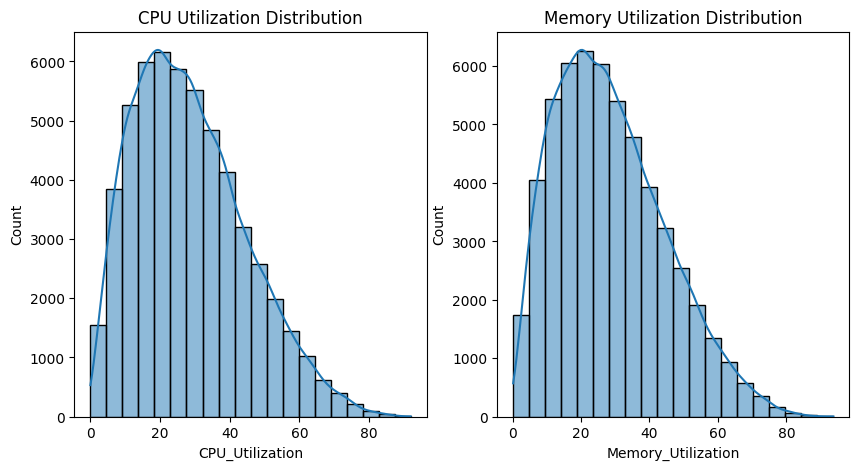

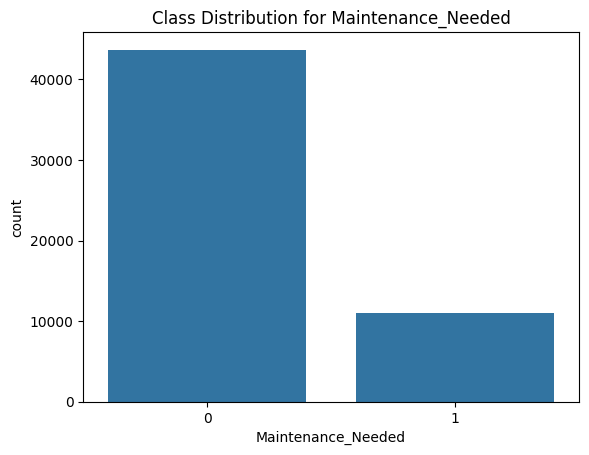

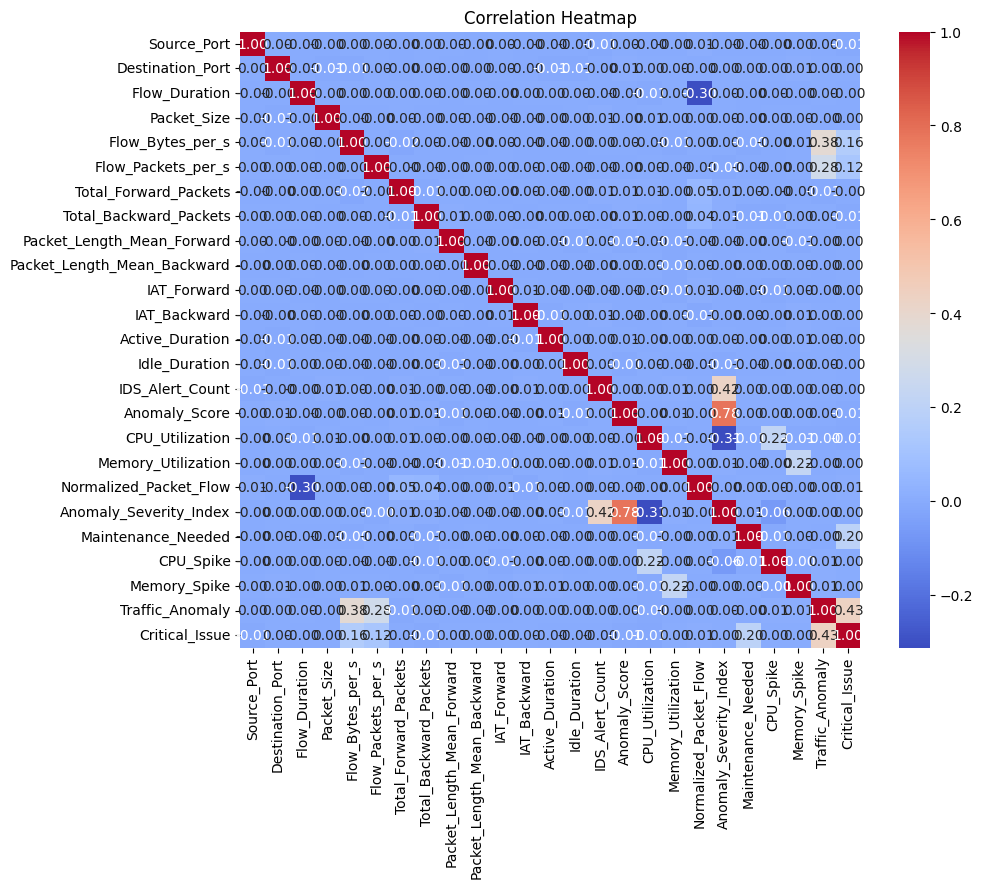

In [15]:
# Visualize distributions of CPU and memory utilization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['CPU_Utilization'], bins=20, kde=True)
plt.title('CPU Utilization Distribution')
plt.subplot(1, 2, 2)
sns.histplot(data['Memory_Utilization'], bins=20, kde=True)
plt.title('Memory Utilization Distribution')
plt.show()

# Check for class balance in Maintenance_Needed
sns.countplot(x='Maintenance_Needed', data=data)
plt.title('Class Distribution for Maintenance_Needed')
plt.show()

# Correlation heatmap
numeric_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
# Spike features
data['CPU_Spike'] = np.abs(data['CPU_Utilization'].diff().fillna(0))
data['Memory_Spike'] = np.abs(data['Memory_Utilization'].diff().fillna(0))


Code: Traffic Anomaly Detection and Critical Issue Analysis


In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# --- Traffic Anomaly Detection ---
# Select features relevant for anomaly detection
anomaly_features = data[['Flow_Bytes_per_s', 'Flow_Packets_per_s']]

# Initialize Isolation Forest for traffic anomaly detection
anomaly_detector = IsolationForest(random_state=42, contamination=0.05)
data['Traffic_Anomaly'] = anomaly_detector.fit_predict(anomaly_features)

# Convert Isolation Forest output: -1 (anomaly) -> 1 (binary for anomaly), 1 (normal) -> 0
data['Traffic_Anomaly'] = data['Traffic_Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Assign anomaly severity levels (High for anomalies, Low otherwise)
data['Anomaly_Severity'] = data['Traffic_Anomaly'].apply(lambda x: 'High' if x == 1 else 'Low')

# --- Generate Alerts ---
# Unified function to generate alerts based on detected issues
def generate_alert(row):
    if row['Traffic_Anomaly'] == 1:
        if row['Anomaly_Severity'] == 'High':
            return 'Security Risk: Immediate investigation required for high anomaly severity.'
    elif row['Maintenance_Needed'] == 1:
        return 'Performance Issue: Review CPU/Memory usage and patch device.'
    return 'No immediate action required.'

# Add a column for Recommended Actions
data['Recommended_Action'] = data.apply(generate_alert, axis=1)

# --- Identify Critical Issues ---
# Define a critical issue as a case where both maintenance and traffic anomalies occur
data['Critical_Issue'] = np.where(
    (data['Maintenance_Needed'] == 1) & (data['Traffic_Anomaly'] == 1), 1, 0
)

# Print summary statistics for critical issues
critical_cases = data[data['Critical_Issue'] == 1]
print(f"Number of devices with critical issues: {len(critical_cases)}")
if len(critical_cases) > 0:
    print(f"Average CPU Utilization (Critical Issues): {critical_cases['CPU_Utilization'].mean():.2f}")
    print(f"Average Memory Utilization (Critical Issues): {critical_cases['Memory_Utilization'].mean():.2f}")
else:
    print("No critical issues detected.")

# --- Logistic Regression for Anomaly Prediction ---
# Define features (X) and target variable (y)
X_health = data[['CPU_Utilization', 'Memory_Utilization', 'Flow_Bytes_per_s', 'Flow_Packets_per_s']]
y_anomaly = data['Traffic_Anomaly']

# Split data into training and test sets
X_train_health, X_test_health, y_train_anomaly, y_test_anomaly = train_test_split(
    X_health, y_anomaly, test_size=0.2, random_state=42
)

# Initialize and train Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_health, y_train_anomaly)

# Predict on the test set
y_pred_anomaly = log_reg_model.predict(X_test_health)

# Evaluate the logistic regression model
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_anomaly, y_pred_anomaly))

# Display feature importance (logistic regression coefficients)
feature_importance = pd.DataFrame(log_reg_model.coef_.T, index=X_health.columns, columns=["Coefficient"])
print("\nFeature Importance (Logistic Regression Coefficients):")
print(feature_importance)

# --- Optionally, Print Critical Case Details ---
if len(critical_cases) > 0:
    print("\nDetails of Critical Issues:")
    for idx, row in critical_cases.iterrows():
        print(f"Row Index: {idx} | "
              f"CPU Utilization: {row['CPU_Utilization']:.1f}% | "
              f"Memory Utilization: {row['Memory_Utilization']:.1f}% | "
              f"Traffic Anomaly Detected: Yes")




Number of devices with critical issues: 538
Average CPU Utilization (Critical Issues): 26.92
Average Memory Utilization (Critical Issues): 29.22

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     10410
           1       0.97      0.46      0.62       544

    accuracy                           0.97     10954
   macro avg       0.97      0.73      0.81     10954
weighted avg       0.97      0.97      0.97     10954


Feature Importance (Logistic Regression Coefficients):
                    Coefficient
CPU_Utilization       -0.001358
Memory_Utilization    -0.000081
Flow_Bytes_per_s       0.323102
Flow_Packets_per_s     1.586338

Details of Critical Issues:
Row Index: 0 | CPU Utilization: 16.4% | Memory Utilization: 60.9% | Traffic Anomaly Detected: Yes
Row Index: 9 | CPU Utilization: 16.2% | Memory Utilization: 15.6% | Traffic Anomaly Detected: Yes
Row Index: 90 | CPU Utilization: 55.0% | Me

Maintenance Prediction


In [17]:
# Random Forest and XGBoost Models for Maintenance Prediction
# Define X and y for model training
X = data.drop(columns=['Maintenance_Needed','Source_IP', 'Destination_IP','Protocol_Type'])
y = data['Maintenance_Needed']

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate through columns and encode any that are of type 'object' (string)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col])

# Replace infinite and large values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Stratified split to maintain class balance in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the model parameters for GridSearchCV
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 10]
}

# Initialize RandomForest and XGBoost models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning with GridSearchCV for RandomForest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='f1', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Hyperparameter tuning with GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='f1', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Get the best models from GridSearchCV
best_rf_model = rf_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

# Train the best models on the training data
best_rf_model.fit(X_train, y_train)
best_xgb_model.fit(X_train, y_train)

# Predict on the test set and evaluate
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)

# Evaluation metrics for Random Forest
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Precision:", precision_score(y_test, rf_predictions))
print("Recall:", recall_score(y_test, rf_predictions))
print("F1 Score:", f1_score(y_test, rf_predictions))

# Evaluation metrics for XGBoost
print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Precision:", precision_score(y_test, xgb_predictions))
print("Recall:", recall_score(y_test, xgb_predictions))
print("F1 Score:", f1_score(y_test, xgb_predictions))
maintenance_cases = data[data['Maintenance_Needed'] == 1]
non_maintenance_cases = data[data['Maintenance_Needed'] == 0]
# Use the one-hot encoded column 'System_Patch_Status_Outdated' for filtering
# The column name was changed after one-hot encoding, so it should be 'System_Patch_Status_Outdated'
#print(f"Devices with outdated patches: {len(data[(data['System_Patch_Status_Outdated'] == 1) & (data['Maintenance_Needed'] == 1)])}")
print(f"Average CPU Utilization (Maintenance Needed): {maintenance_cases['CPU_Utilization'].mean():.2f}")
print(f"Average Memory Utilization (Maintenance Needed): {maintenance_cases['Memory_Utilization'].mean():.2f}")
print(f"Average CPU Utilization (No Maintenance Needed): {non_maintenance_cases['CPU_Utilization'].mean():.2f}")
print(f"Average Memory Utilization (No Maintenance Needed): {non_maintenance_cases['Memory_Utilization'].mean():.2f}")

from sklearn.metrics import confusion_matrix

# For Random Forest
print("Confusion Matrix (Random Forest):")
rf_cm = confusion_matrix(y_test, rf_predictions)
print(rf_cm)

# For XGBoost
print("\nConfusion Matrix (XGBoost):")
xgb_cm = confusion_matrix(y_test, xgb_predictions)
print(xgb_cm)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:47:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:47:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

XGBoost Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Average CPU Utilization (Maintenance Needed): 28.52
Average Memory Utilization (Maintenance Needed): 28.57
Average CPU Utilization (No Maintenance Needed): 28.74
Average Memory Utilization (No Maintenance Needed): 28.72
Confusion Matrix (Random Forest):
[[8742    0]
 [   0 2212]]

Confusion Matrix (XGBoost):
[[8742    0]
 [   0 2212]]


Critical Issue Detection

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Define X and y
X = data[['CPU_Utilization', 'Memory_Utilization', 'Flow_Bytes_per_s', 'Flow_Packets_per_s']]

# Check if 'System_Patch_Status_Up-to-date' exists in the columns
if 'System_Patch_Status' in data.columns:
    X = pd.concat([X, data[['System_Patch_Status_Up-to-date']]], axis=1)
else:
    print("Warning: 'System_Patch_Status_Up-to-date' not found in columns. Skipping.")

y_critical = data['Critical_Issue']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_critical, test_size=0.2, stratify=y_critical, random_state=42)

# Train RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
print("\nCritical Issue Detection (Random Forest):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, rf_predictions))




Critical Issue Detection (Random Forest):
Accuracy: 0.9894102610918386
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix (Random Forest):
[[8659 2187]
 [  83   25]]


In [11]:
# Generate detailed alerts for critical devices
critical_devices = data[data['Critical_Issue'] == 1]
for idx, row in critical_devices.iterrows():
    print(f"Device {idx} Alert: High CPU Utilization ({row['CPU_Utilization']*100:.1f}%) and "
          f"Memory Utilization ({row['Memory_Utilization']*100:.1f}%), with traffic anomalies detected. "
          f"Source IP: {row.get('Source_IP', 'N/A')}, Destination IP: {row.get('Destination_IP', 'N/A')}. "
          f"Recommended Action: {row['Recommended_Action']}. Immediate review recommended.")



Device 0 Alert: High CPU Utilization (1637.5%) and Memory Utilization (6091.9%), with traffic anomalies detected. Source IP: 192.168.1.1, Destination IP: 8.8.8.8. Recommended Action: Security Risk: Immediate investigation required for high anomaly severity.. Immediate review recommended.
Device 9 Alert: High CPU Utilization (1622.4%) and Memory Utilization (1564.4%), with traffic anomalies detected. Source IP: 10.0.0.1, Destination IP: 4.4.4.4. Recommended Action: Security Risk: Immediate investigation required for high anomaly severity.. Immediate review recommended.
Device 90 Alert: High CPU Utilization (5501.9%) and Memory Utilization (2625.8%), with traffic anomalies detected. Source IP: 192.168.1.1, Destination IP: 8.8.8.8. Recommended Action: Security Risk: Immediate investigation required for high anomaly severity.. Immediate review recommended.
Device 341 Alert: High CPU Utilization (3704.0%) and Memory Utilization (2874.3%), with traffic anomalies detected. Source IP: 192.168.